# Variable vs Constant Replication

In [1]:
#!pip install lifelines

In [2]:
from lifelines import KaplanMeierFitter
from lifelines.utils import survival_table_from_events
from lifelines.statistics import logrank_test
from lifelines import NelsonAalenFitter
from lifelines.plotting import add_at_risk_counts
from lifelines import CoxPHFitter
import itertools
import datetime
import json
import hashlib
from pprint import pprint

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.optimize import least_squares
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from __future__ import print_function
%matplotlib inline

In [4]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 14,
        }

In [5]:
with open("vc_results.json", 'rU') as fd:
    dj = json.load(fd)

In [6]:
df = pd.read_json(dj, orient="columns")

In [7]:
df["MUTATE_PROB"] = pd.to_numeric(df["MUTATE_PROB"].round(decimals=5))

In [8]:
df.head()

ATP  CARRYC           DESCRIPTION     E  MPROB  MUTATE_PROB  NO_MTDNA  \
0    18000    2000  wild type extinction  True  0.001      0.00025      1998   
1    18000    2000  wild type extinction  True  0.001      0.00025      2005   
10   18000    2000  wild type extinction  True  0.001      0.00025      2001   
100  18000    2000  wild type extinction  True  0.002      0.00050      1998   
101  18000    2000  wild type extinction  True  0.002      0.00050      1997   

     NO_SPECIES REPL_TIME  SAMPLE_PER_HOUR    TIME  TOTAL_SPECIES  halflife  
0             9  variable                4  354435            130        10  
1             4  variable                4  294262            118        10  
10            5  variable                4  258930            101        10  
100           3  constant                4  578794            418        10  
101          11  constant                4  796911            594        10

In [9]:
sample_per_day = 24 * df['SAMPLE_PER_HOUR'][1]; 

In [10]:
mprobs = [("%se-3" % (i), float("{:.5f}".format((i * 1e-3)))) for i in range(1,10)]
mprobs.append(("1e-2", 0.01))

In [11]:
mprob_lst = []
prop_res = []

In [12]:
med_lst = []

In [13]:
for x,p in mprobs:
    #gtitle = "mutation probability: %s" % (x)
    groups = df['REPL_TIME'][df.MPROB == p]
    ix = (groups == 'constant')
    T = df['TIME'][df.MPROB == p]/float(sample_per_day*365)
    E = df['E'][df.MPROB == p]
    kmf = KaplanMeierFitter()
    kmf.fit(T[~ix], E[~ix], label='variable', alpha=0.95)
    med_lst.append(kmf.median_)
    #ax = kmf.plot(title=gtitle, show_censors=True)
    #kmf.fit(T[ix], E[ix], label='constant')
    #kmf.plot(ax=ax, show_censors=True)

## Regression Analysis

In [14]:
X_train = np.array([y for x,y in mprobs])
Y_train = np.array(med_lst)
gradient, intercept, r_value, p_value, std_err = stats.linregress(X_train,Y_train)

In [15]:
font2 = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 14,
        }

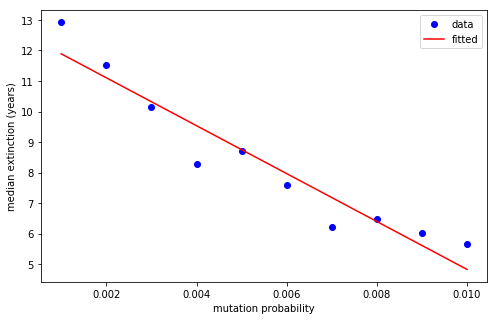

In [16]:
plt.figure(figsize=(8,5))
plt.plot(X_train, Y_train, 'bo', label="data")
plt.plot(X_train, gradient*X_train + intercept, 'r-', label="fitted")
plt.ylabel("median extinction (years)")
plt.xlabel("mutation probability")
#plt.ylim((0,17))
plt.legend()
#plt.text(0.00168, 4, "slope: %.2f" % (gradient), fontdict=font)
#plt.text(0.001, 3, "intercept: %.2f" % (intercept), fontdict=font)
plt.show()

In [17]:
def func(x, a, b, c):
     return a * np.exp(-b * x) + c

In [18]:
init_vals = [1, 0, 1]

In [19]:
popt, pcov = curve_fit(func, X_train, Y_train)

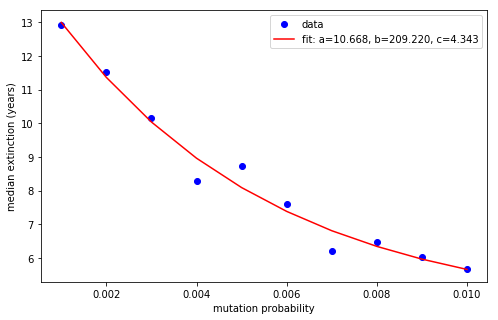

In [20]:
plt.figure(figsize=(8,5))
plt.plot(X_train, Y_train, 'bo', label="data")
plt.plot(X_train, func(X_train, *popt), 'r-',  label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

#plt.plot(X_train, gradient * X_train + intercept, 'r-', label="fitted")
plt.ylabel("median extinction (years)")
plt.xlabel("mutation probability")

plt.legend()
plt.show()

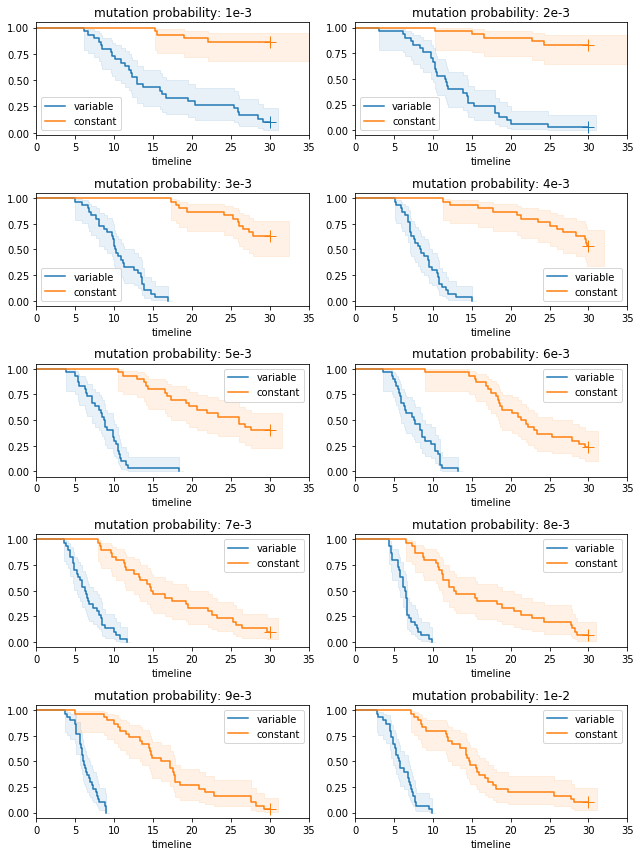

In [21]:
k = 0
ax = {}
f = plt.figure(figsize=(9,20))
for x,p in [mprobs[i] for i in [0,1,2,3,4,5,6,7,8,9]]:
    ax[x] = f.add_subplot(5, 2, k+1)
    gtitle = "mutation probability: %s" % (x)
    groups = df['REPL_TIME'][df.MPROB == p]
    ix = (groups == 'constant')
    T = df['TIME'][df.MPROB == p]/float(96*365)
    E = df['E'][df.MPROB == p]
    
    f.set_figheight(12)
    
    kmf = KaplanMeierFitter()
    kmf.fit(T[~ix], E[~ix], label='variable')
    prop_res.append(kmf.median_)
    mprob_lst.append(p)
    
    kmf.plot(ax=ax[x], title=gtitle, xlim=(0,35), show_censors=True, ci_alpha=0.1,  ci_force_lines=False)
    kmf.fit(T[ix], E[ix], label='constant')
    kmf.plot(ax=ax[x], show_censors=True, ci_alpha=0.1,  ci_force_lines=False)
    f.tight_layout()
    #f.legend((l1, l2), ('Line 1', 'Line 2'), 'upper left')
    k+=1